<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/MDF_para_transporte_de_esp%C3%A9cies_%C3%B3leo_agua_e_meg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

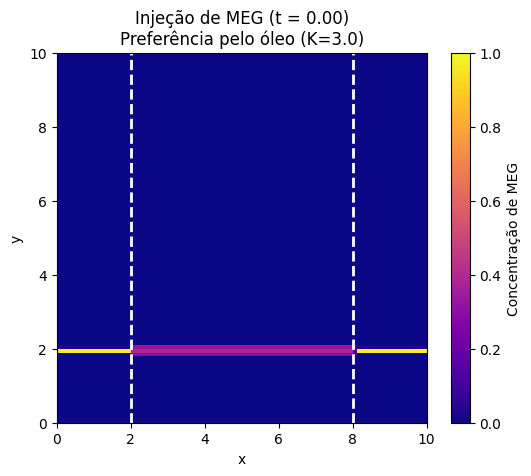

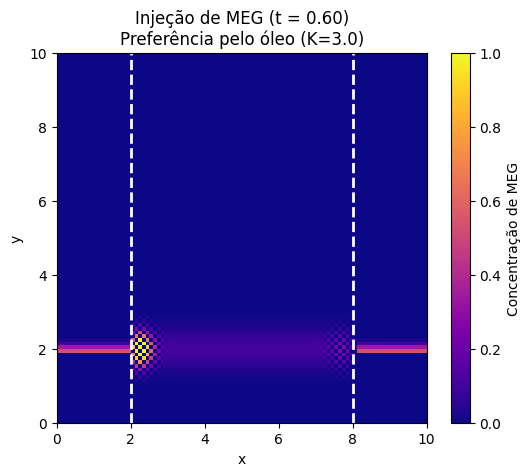

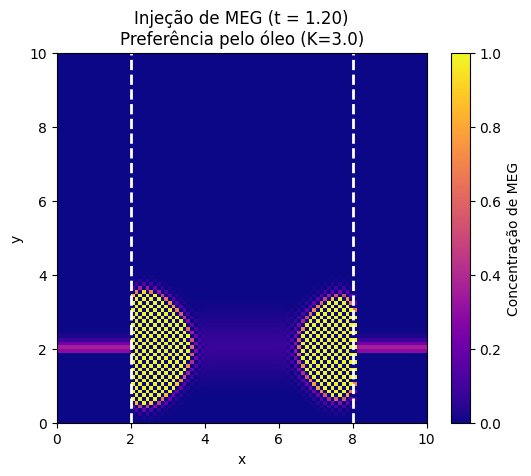

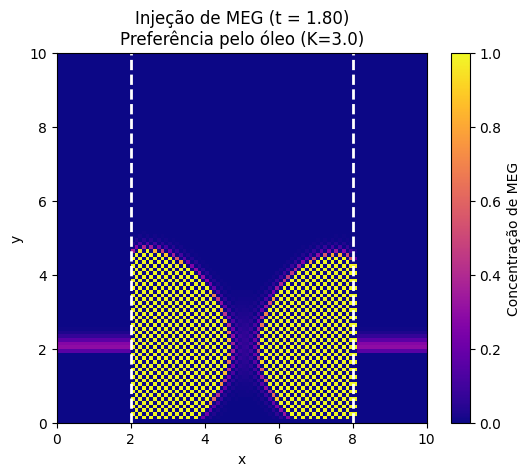

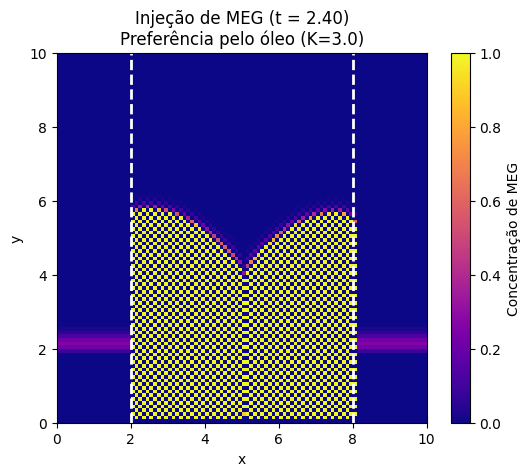

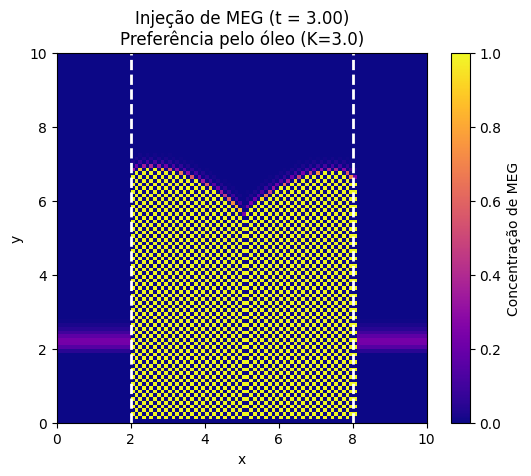

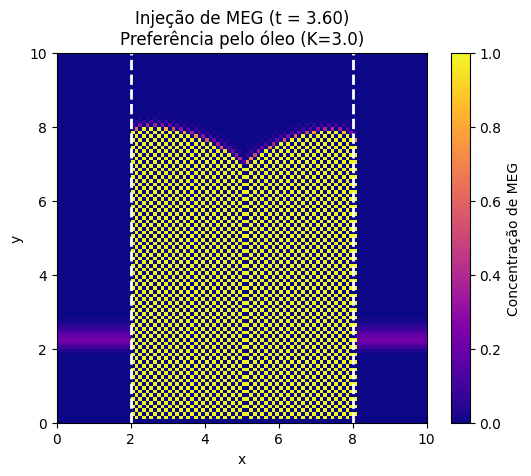

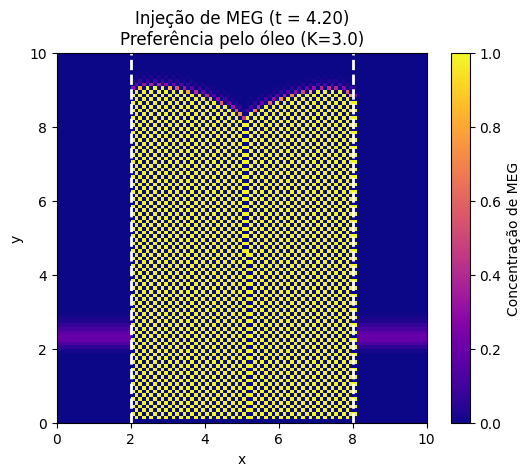

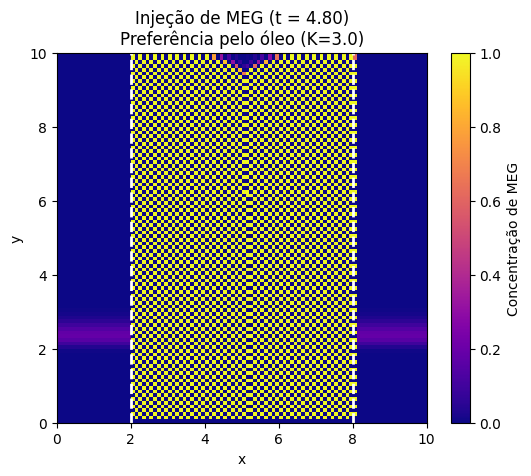

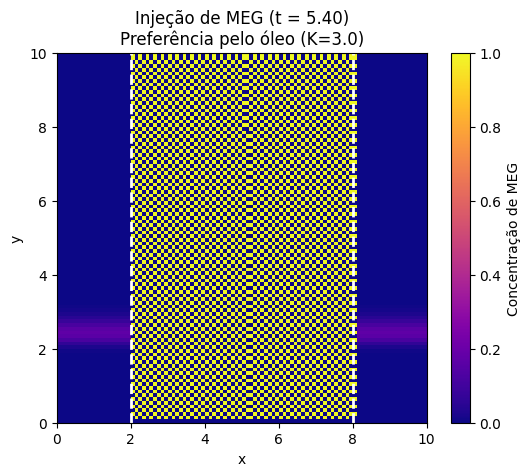

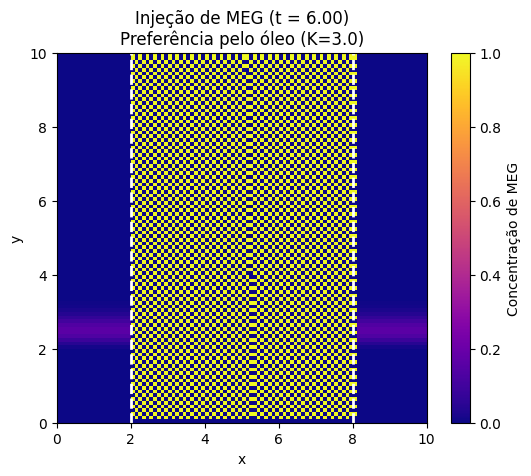

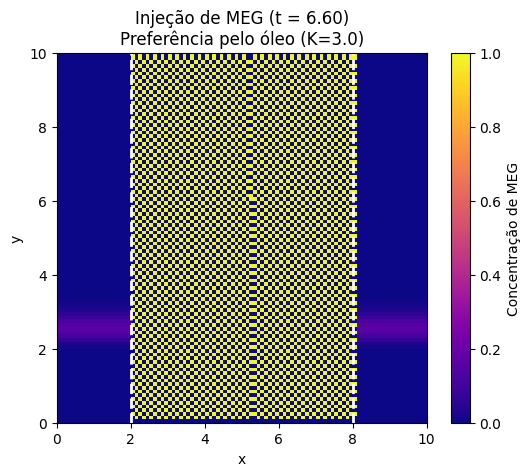

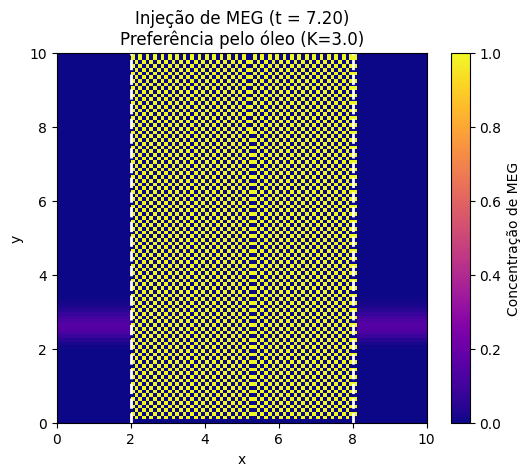

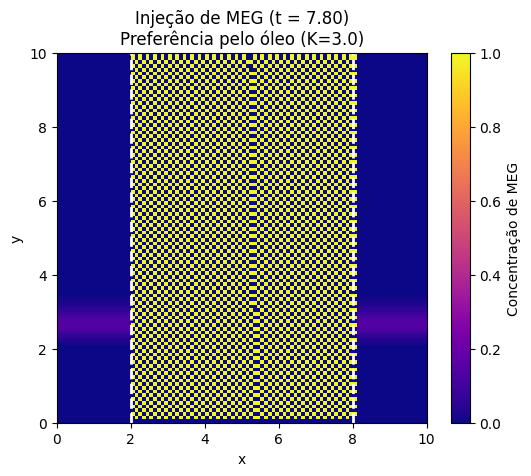

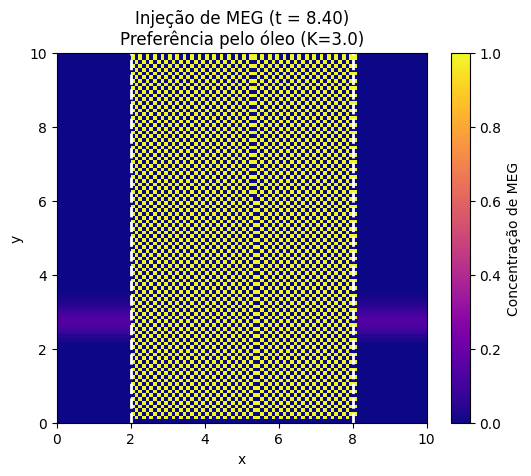

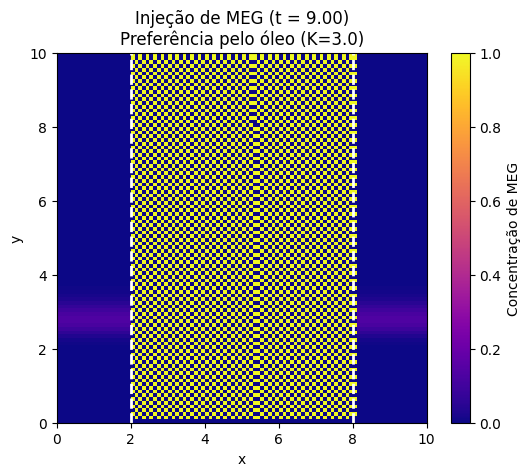

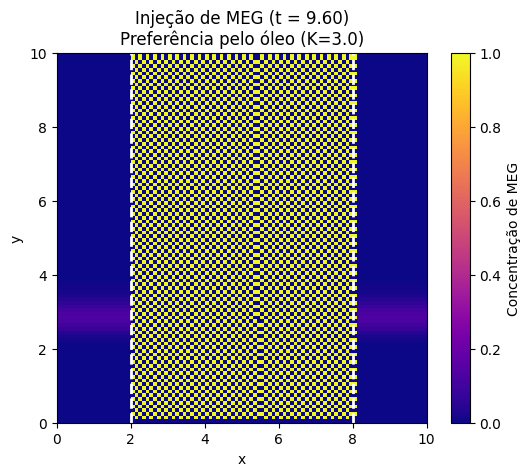

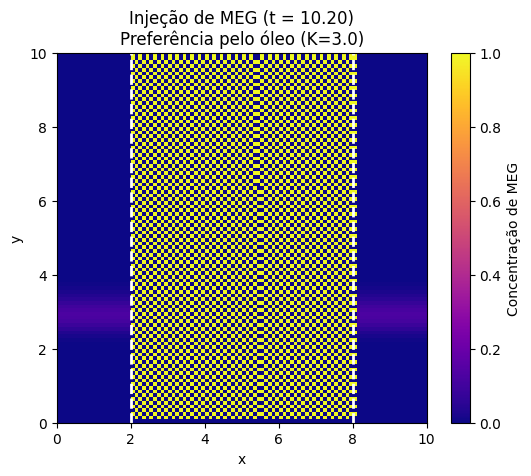

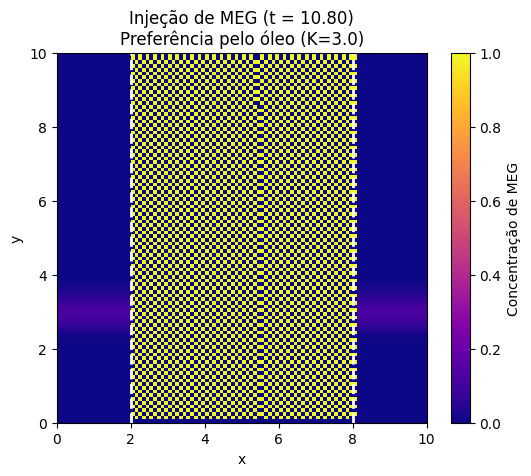

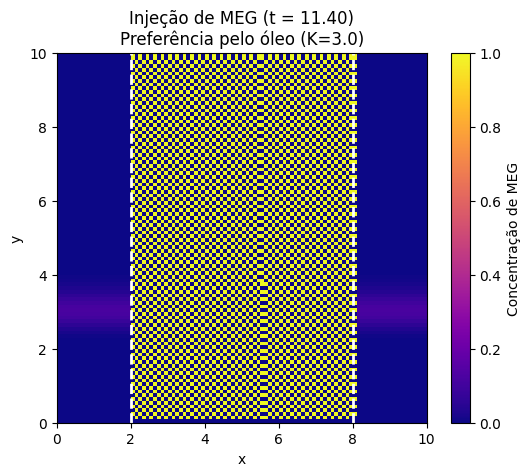

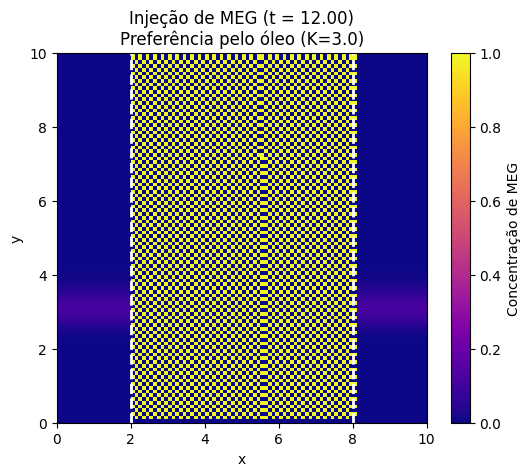

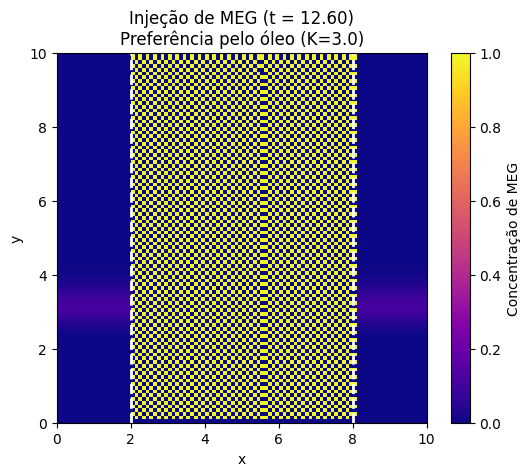

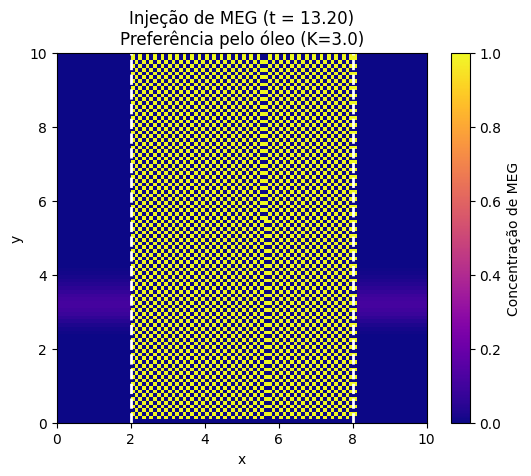

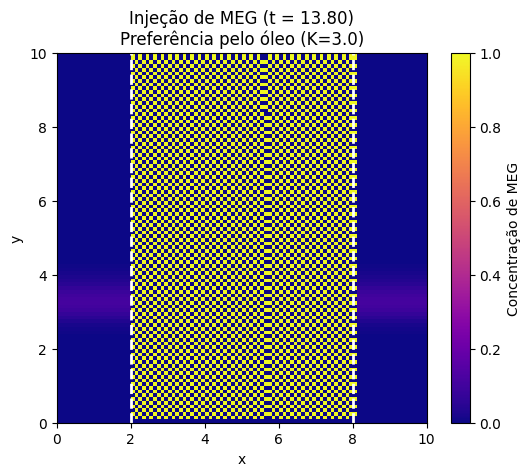

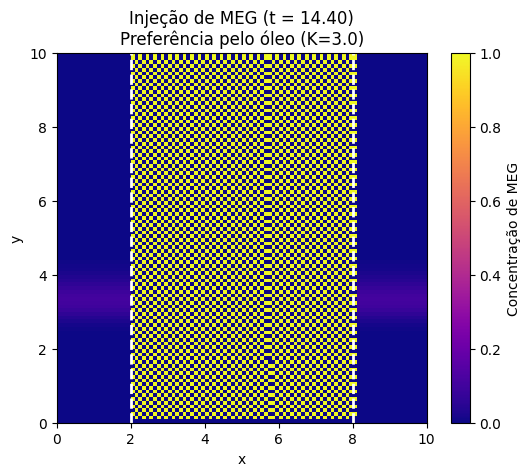

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Configuração do domínio
Lx, Ly = 10.0, 10.0 #Não sei, quando tentei 0.12 em x, deu problema de overflow, provavelmente ignorei o cfl. deixei domínio retangular
nx, ny = 100, 100
dx, dy = Lx/(nx-1), Ly/(ny-1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
T = 15.0
nt = 500
dt = T / nt

# Definição das fases (1=Água, 2=Óleo)
fase = np.ones((ny, nx))
fase[:, (X[0,:] >= 2) & (X[0,:] <= 8)] = 2  # Óleo em 2 ≤ x ≤ 8m isso aqui é para forçar o anular

# Parâmetros físicos
u_agua, v_agua = 0.0, 0.1  # Água flui em x
u_oleo, v_oleo = 0.0, 0.1   # Óleo mais lento
D_agua, D_oleo = 0.0, 0.1  # Difusividades

# Coeficientes de partição MEG
K_MEG_oleo = 3.0  #Não sei, mas acredito que o MEG vai dar preferência por se difundir no óleo, né?
K_MEG_agua = 0.0

# Condição inicial do MEG (injetado em y=2, estimando, o duto real seria em uns 5m)
C_MEG = np.zeros((ny, nx))
C_MEG[int(2/dy), :] = 1.0

for n in range(nt):
    C_MEG_new = np.copy(C_MEG)
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            if fase[i,j] == 1:  # Água
                u, v, D = u_agua, v_agua, D_agua
                K = K_MEG_agua
            else:  # Óleo
                u, v, D = u_oleo, v_oleo, D_oleo
                K = K_MEG_oleo

            # Advecção (upwind)
            adv_x = u * (C_MEG[i,j] - C_MEG[i,j-1]) / dx if u > 0 else u * (C_MEG[i,j+1] - C_MEG[i,j]) / dx
            adv_y = v * (C_MEG[i,j] - C_MEG[i-1,j]) / dy if v > 0 else v * (C_MEG[i+1,j] - C_MEG[i,j]) / dy

            # Difusão
            diff_x = D * (C_MEG[i,j+1] - 2*C_MEG[i,j] + C_MEG[i,j-1]) / dx**2
            diff_y = D * (C_MEG[i+1,j] - 2*C_MEG[i,j] + C_MEG[i-1,j]) / dy**2

            C_MEG_new[i,j] = C_MEG[i,j] + dt * (-adv_x - adv_y + diff_x + diff_y)

    # Condições de interface (x=2 e x=8) esse aqui eu pedi ajuda ao gpt, pq nao tava sabendo implementar. Pode (e provavelmente tem erro!)
    for x_interface in [2, 8]:
        j = np.argmin(np.abs(x - x_interface))
        for i in range(ny):
            if x_interface == 2 and fase[i,j] == 1 and fase[i,j+1] == 2:  # Água -> Óleo
                C_MEG_new[i,j+1] = K_MEG_oleo * C_MEG_new[i,j]  # MEG migra para o óleo
            elif x_interface == 8 and fase[i,j] == 2 and fase[i,j+1] == 1:  # Óleo -> Água
                C_MEG_new[i,j+1] = C_MEG_new[i,j] / K_MEG_oleo  # MEG sai do óleo


    #C_MEG_new[0, :] = 0.0

    # Condições de contorno (fluxo zero nas laterais e topo)
    C_MEG_new[:,0] = C_MEG_new[:,1]
    C_MEG_new[:,-1] = C_MEG_new[:,-2]
    C_MEG_new[-1,:] = C_MEG_new[-2,:]

    C_MEG = np.copy(C_MEG_new)

    # Plot
    if n % 20 == 0:
        plt.clf()
        plt.imshow(C_MEG, extent=[0, Lx, 0, Ly], origin='lower', cmap='plasma', vmin=0, vmax=1)
        plt.colorbar(label='Concentração de MEG')
        plt.axvline(x=2, color='white', linestyle='--', linewidth=2)
        plt.axvline(x=8, color='white', linestyle='--', linewidth=2)
        plt.title(f'Injeção de MEG (t = {n*dt:.2f})\nPreferência pelo óleo (K={K_MEG_oleo})')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.pause(0.01)

plt.show()